In [108]:
from sklearn.datasets import fetch_openml
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Load MNIST dataset
mnist = fetch_openml('mnist_784', version=1)
X, y = mnist['data'], mnist['target']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

C:\Users\Yaros\Skoltech\env\Lib\site-packages\sklearn\datasets\_openml.py:1022: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


In [161]:
# Initialize the Decision Tree Classifier
clf = DecisionTreeClassifier(max_depth=4)

# Train the classifier
clf.fit(X_train, y_train)

# Predict on the test set
y_pred = clf.predict(X_test)

# Calculate the accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

Accuracy: 0.5630714285714286


In [61]:
from sklearn import tree

[Text(0.5, 0.9, 'x[350] <= 126.5\ngini = 0.9\nsamples = 56000\nvalue = [5560, 6277, 5610, 5708, 5529, 5040, 5480, 5790, 5468\n5538]'),
 Text(0.25, 0.7, 'x[435] <= 0.5\ngini = 0.88\nsamples = 36152\nvalue = [5106, 544, 4450, 1137, 5031, 2973, 4384, 5290, 2830\n4407]'),
 Text(0.125, 0.5, 'x[597] <= 1.5\ngini = 0.688\nsamples = 9561\nvalue = [4979, 30, 582, 258, 399, 858, 538, 1414, 110, 393]'),
 Text(0.0625, 0.3, 'x[486] <= 0.5\ngini = 0.787\nsamples = 3516\nvalue = [425, 20, 119, 81, 388, 362, 338, 1376, 35, 372]'),
 Text(0.03125, 0.1, 'gini = 0.59\nsamples = 2124\nvalue = [170, 19, 41, 61, 82, 205, 38, 1316, 12, 180]'),
 Text(0.09375, 0.1, 'gini = 0.834\nsamples = 1392\nvalue = [255, 1, 78, 20, 306, 157, 300, 60, 23, 192]'),
 Text(0.1875, 0.3, 'x[489] <= 16.5\ngini = 0.418\nsamples = 6045\nvalue = [4554, 10, 463, 177, 11, 496, 200, 38, 75, 21]'),
 Text(0.15625, 0.1, 'gini = 0.263\nsamples = 5172\nvalue = [4424, 5, 105, 161, 6, 278, 133, 22, 19, 19]'),
 Text(0.21875, 0.1, 'gini = 0.737\

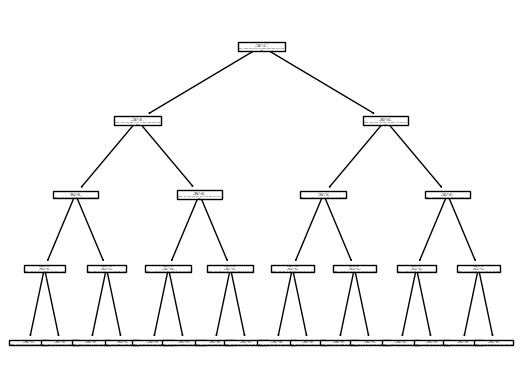

In [162]:
tree.plot_tree(clf)

In [163]:
# Number of nodes in the tree
print(f"Number of nodes: {clf.tree_.node_count}")

# Function to calculate the depth of the decision tree
def tree_depth(tree):
    """
    This function recursively finds the depth of a decision tree.
    """
    def _walk(node_id, current_depth):
        left_child = tree.children_left[node_id]
        right_child = tree.children_right[node_id]
        if left_child == right_child:  # leaf node
            return current_depth
        return max(_walk(left_child, current_depth + 1),
                   _walk(right_child, current_depth + 1))

    root_node_id = 0
    return _walk(root_node_id, 1)

# Calculate and print the depth of the tree
depth = tree_depth(clf.tree_)
print(f"Depth of the tree: {depth}")

Number of nodes: 31
Depth of the tree: 5


In [164]:
from scipy.sparse import csr_matrix

def create_adjacency_matrix(tree):
    """
    Create an adjacency matrix in CSR format for the given decision tree.
    """
    # Number of nodes in the tree
    n_nodes = tree.node_count

    # Initialize the lists to create CSR matrix
    data = []
    row_ind = []
    col_ind = []

    # Iterate over each node in the tree
    for node in range(n_nodes):
        left_child = tree.children_left[node]
        right_child = tree.children_right[node]

        # Check if the left child exists
        if left_child != -1:
            # Add an edge from the current node to the left child
            row_ind.append(node)
            col_ind.append(left_child)
            data.append(1)  # weight of the edge

        # Check if the right child exists
        if right_child != -1:
            # Add an edge from the current node to the right child
            row_ind.append(node)
            col_ind.append(right_child)
            data.append(1)  # weight of the edge

    # Create the CSR matrix
    adjacency_matrix = csr_matrix((data, (row_ind, col_ind)), shape=(n_nodes, n_nodes))
    return adjacency_matrix

# Create the adjacency matrix for the decision tree
adjacency_matrix = create_adjacency_matrix(clf.tree_)

In [165]:
adjacency_matrix

<31x31 sparse matrix of type '<class 'numpy.intc'>'
	with 30 stored elements in Compressed Sparse Row format>

In [166]:
import math
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial.distance import pdist, squareform
from scipy.sparse import csr_matrix, eye
from scipy.sparse.csgraph import laplacian
from scipy.sparse.linalg import eigsh

In [357]:
def laplacian_eigenmaps(
    adjacency_matrix: csr_matrix,
    embed_dim: int,
    norm_laplacian: bool = False,
) -> np.ndarray:
  L, D = laplacian(adjacency_matrix.astype('float32'), normed=norm_laplacian, symmetrized=True, return_diag=True)
  L *= -1
  L += eye(*L.shape)
  eigenvals, eigenvecs = eigsh(L, k=embed_dim + 1, sigma=1.0, which='LM')

  # drop the zero eigenvalue and constant eigenvector
  eigenvals = eigenvals[:-1]
  eigenvecs = eigenvecs[:, :-1]

  eigenvals = 1 - eigenvals
  eigenvecs = eigenvecs / D[:, None]

  return eigenvals, eigenvecs

In [358]:
eigvals, eigvecs = laplacian_eigenmaps(adjacency_matrix, embed_dim=10)

In [359]:
eigvals

array([0.72438755, 0.31333772, 0.2863605 , 0.26794919, 0.26794917,
       0.15578556, 0.10334139, 0.08949495, 0.04044432, 0.        ])

In [360]:
eigvecs.shape

(31, 10)

<Axes: >

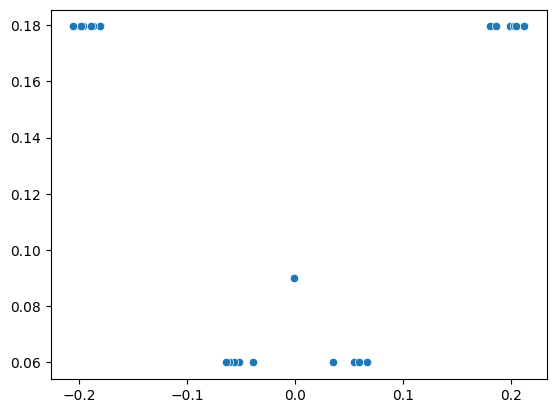

In [361]:
sns.scatterplot(x=eigvecs[:, -2], y=eigvecs[:, -1])

In [305]:
def plot_graph_with_edges(eigvec1, eigvec2, adjacency_matrix,title = 'Graph with Edges'):
    # Use first two eigenvectors for 2D plot coordinates
    x = eigvec1
    y = eigvec2

    # Plot nodes
    plt.scatter(x, y)

    # Draw edges
    rows, cols = adjacency_matrix.nonzero()
    for i in range(len(rows)):
        plt.plot([x[rows[i]], x[cols[i]]], [y[rows[i]], y[cols[i]]], 'k-', alpha=0.5)
    
    plt.xlabel('Eigenvector 1')
    plt.ylabel('Eigenvector 2')
    plt.title(title)
    plt.savefig(title+'.png')
    plt.show()
    
# Assuming eigvecs and adjacency_matrix are defined
# plot_graph_with_edges(eigvecs, adjacency_matrix)

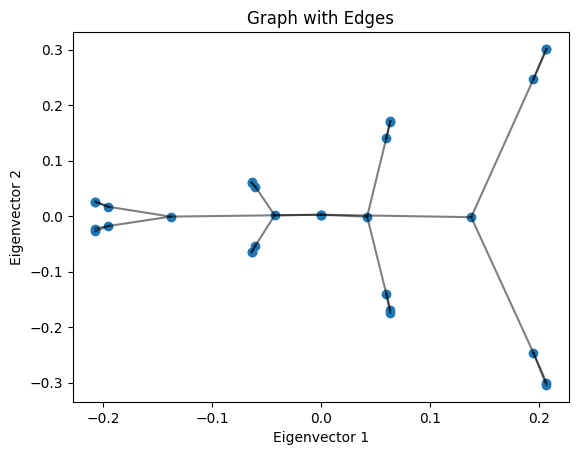

In [356]:
plot_graph_with_edges(eigvecs[:,-3], eigvecs[:,-4], adjacency_matrix)

In [151]:
from scipy.sparse import csr_matrix, hstack, vstack, diags
from scipy.sparse.csgraph import laplacian

def hyperbolic_laplacian(adjacency_matrix: csr_matrix, alpha: [float]) -> csr_matrix:
    """
    Create a hyperbolic Laplacian matrix for a given adjacency matrix and alpha vector.

    :param adjacency_matrix: Sparse adjacency matrix of the graph.
    :param alpha: Vector of alpha values.
    :return: Sparse hyperbolic Laplacian matrix.
    """
    # Calculate the classic Laplacian matrix
    classic_laplacian = laplacian(adjacency_matrix, normed=False, symmetrized=True)

    # Modify the diagonal of the classic Laplacian by subtracting alpha
    modified_laplacian = classic_laplacian - diags(alpha, offsets=0)

    # Create the top row [-1, alpha^T] and bottom rows [alpha, modified_laplacian]
    top_row = hstack((csr_matrix([[-1]]), csr_matrix([alpha])))
    bottom_rows = hstack((csr_matrix(alpha).reshape(-1, 1), modified_laplacian))

    # Stack top row and bottom rows vertically
    hyperbolic_laplacian_matrix = vstack((top_row, bottom_rows))

    return hyperbolic_laplacian_matrix

In [239]:
# Assuming adjacency_matrix is defined
n = adjacency_matrix.shape[0]
alphas = 1./n * np.ones(n)  # Create a 1D array for alphas

hlap = hyperbolic_laplacian(adjacency_matrix, alphas)

In [240]:
hlap.shape

(32, 32)

In [281]:
def hyperbolic_laplacian_eigenmaps(adjacency_matrix: csr_matrix, alpha: np.ndarray, embed_dim: int) -> np.ndarray:
    """
    Compute the eigenvalues and eigenvectors of the hyperbolic Laplacian matrix.

    :param adjacency_matrix: Sparse adjacency matrix of the graph.
    :param alpha: 1D numpy array of alpha values for the hyperbolic Laplacian.
    :param embed_dim: Number of dimensions for embedding (number of eigenvalues/vectors to compute).
    :return: Tuple of eigenvalues and eigenvectors.
    """
    # Compute the hyperbolic Laplacian matrix
    h_laplacian = hyperbolic_laplacian(adjacency_matrix, alpha)

    

    # Calculate the eigenvalues and eigenvectors
    eigenvals, eigenvecs = eigsh(h_laplacian, k=embed_dim, which='SM')

    return eigenvals, eigenvecs

In [310]:
n = adjacency_matrix.shape[0]
embed_dim = 10
heigvals, heigvecs = hyperbolic_laplacian_eigenmaps(adjacency_matrix, alpha = 1./n * np.ones(n) , embed_dim=embed_dim)

In [311]:
heigvals

array([1.34441069e-16, 8.05339667e-03, 6.45300096e-02, 6.45300096e-02,
       2.35691128e-01, 2.35691128e-01, 2.35691128e-01, 2.35691128e-01,
       6.79496324e-01, 9.67741935e-01])

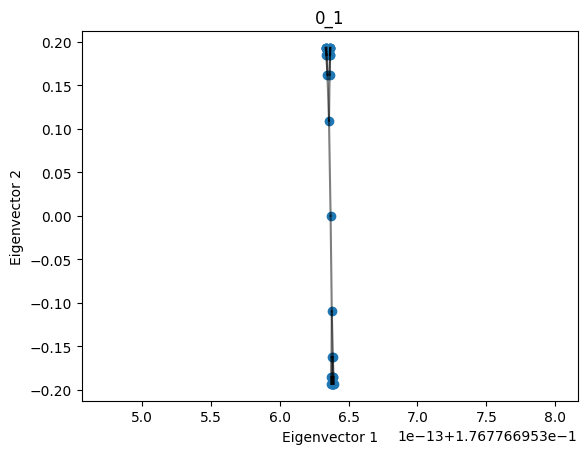

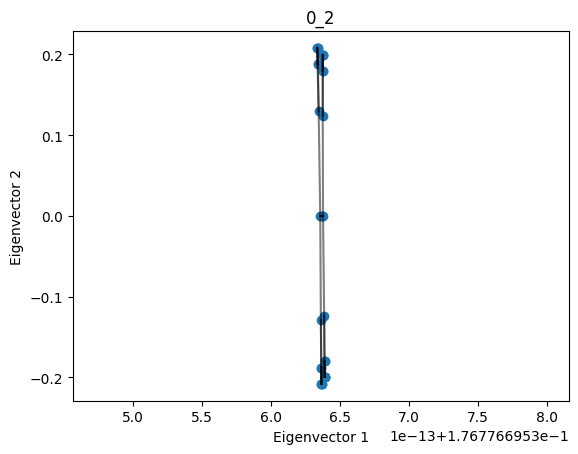

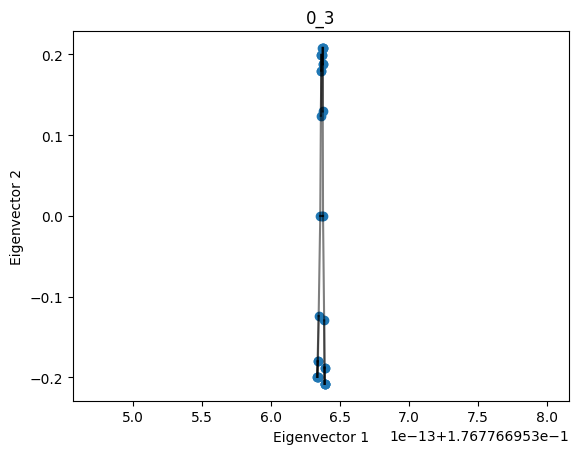

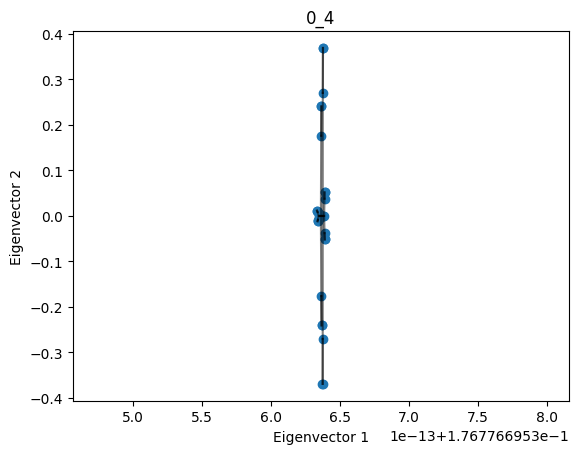

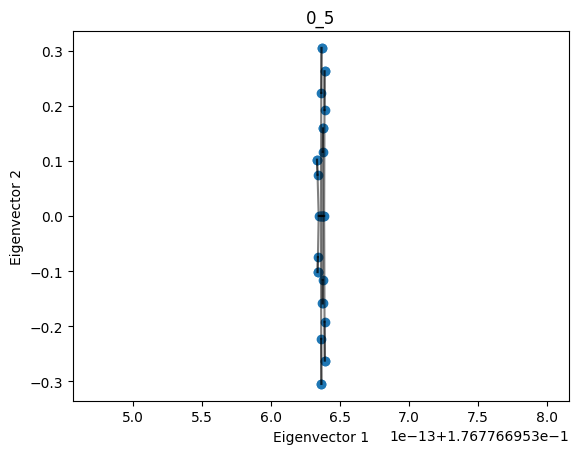

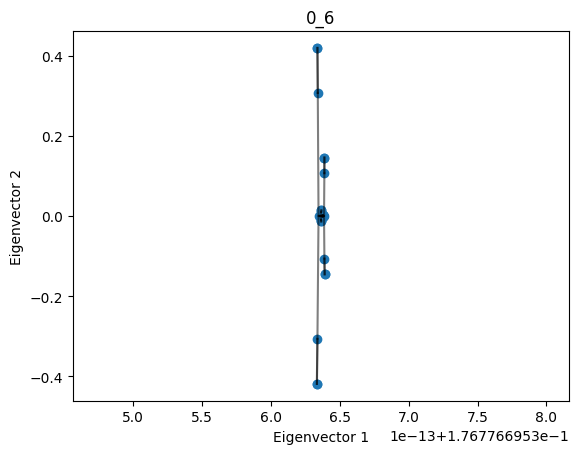

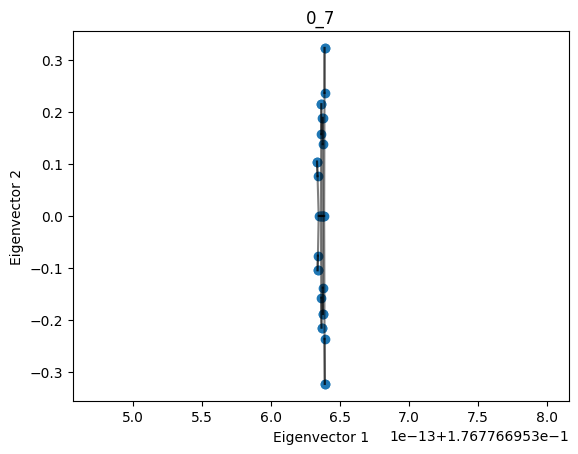

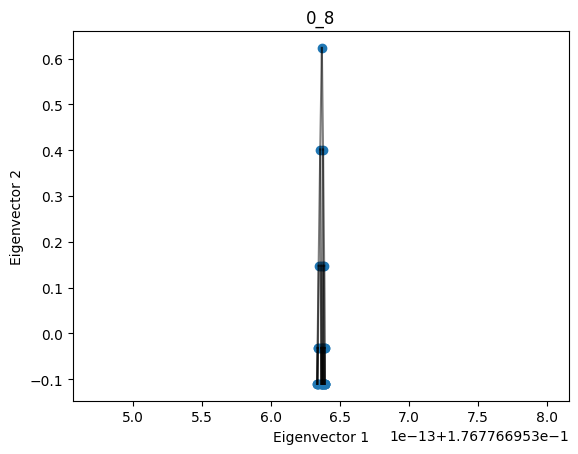

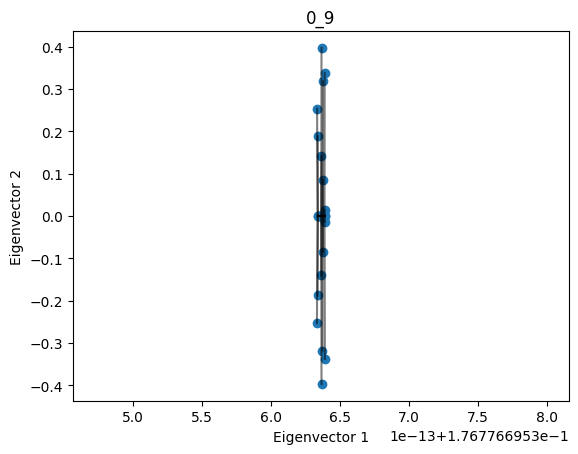

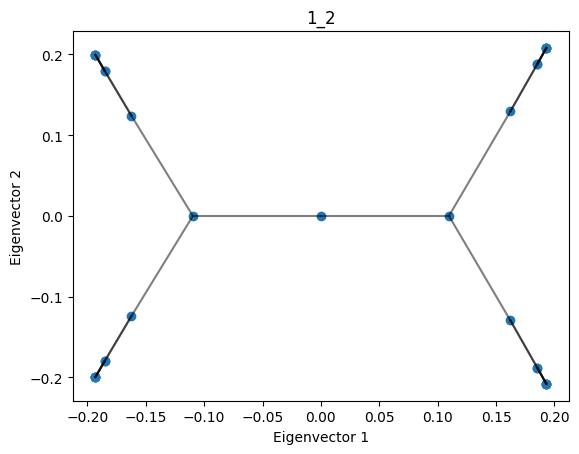

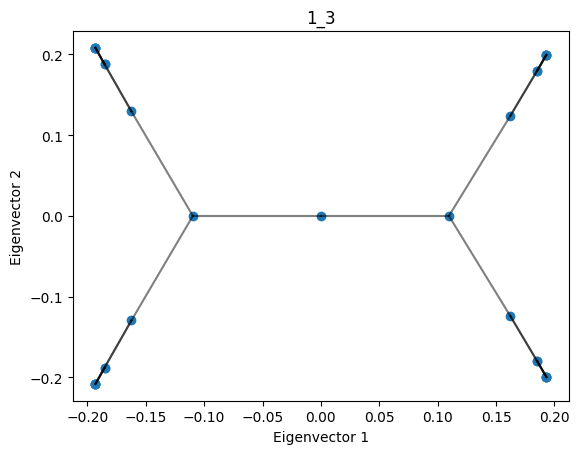

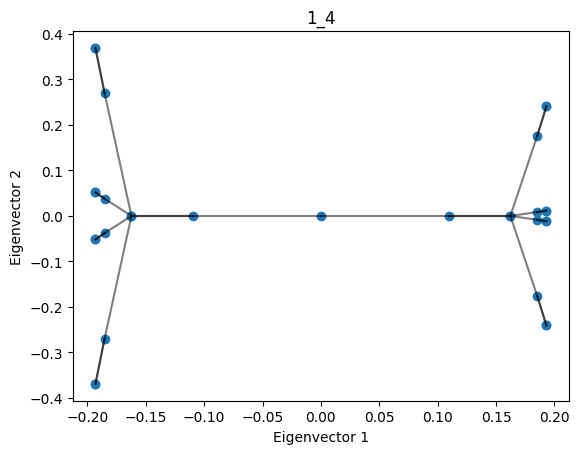

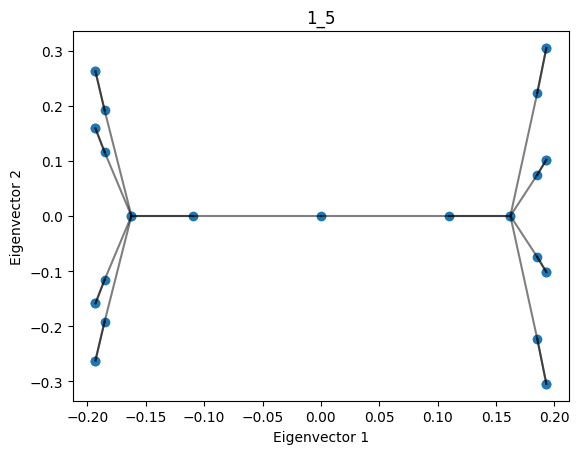

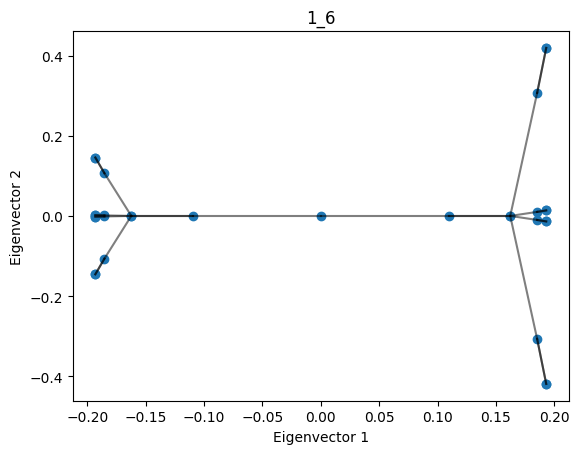

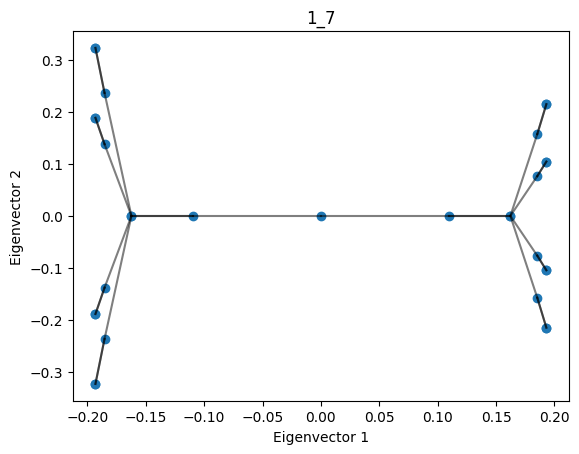

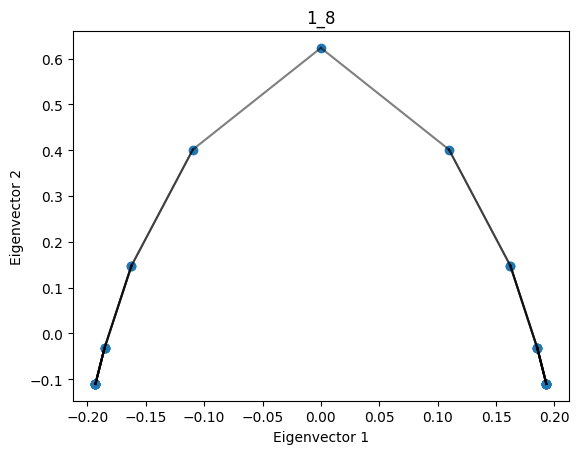

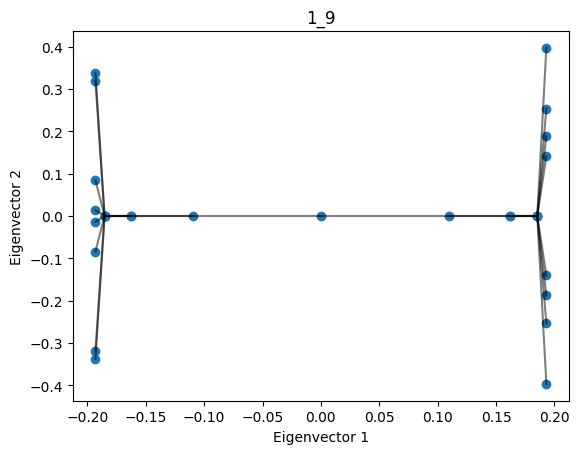

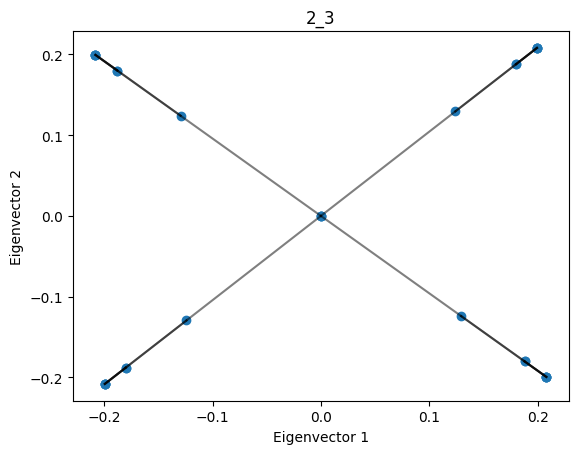

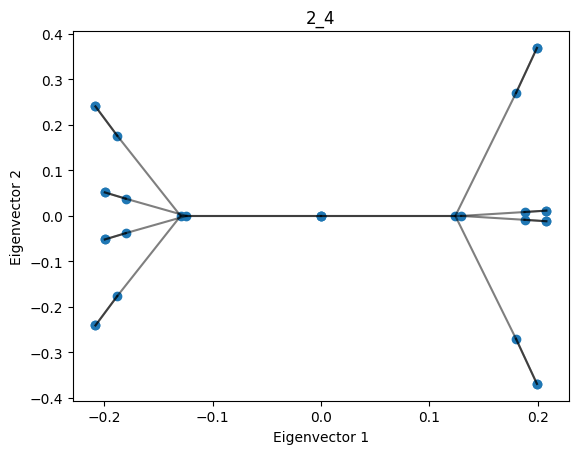

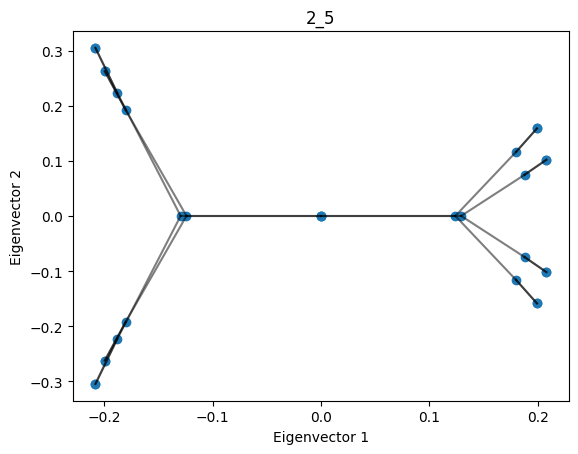

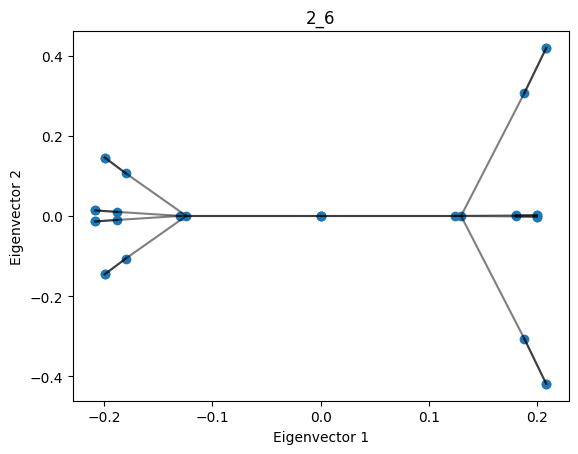

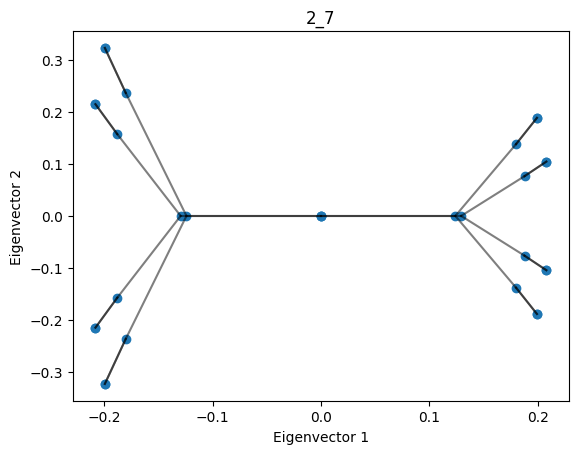

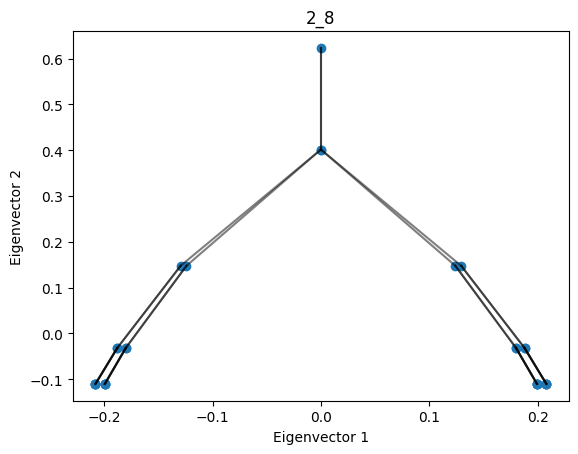

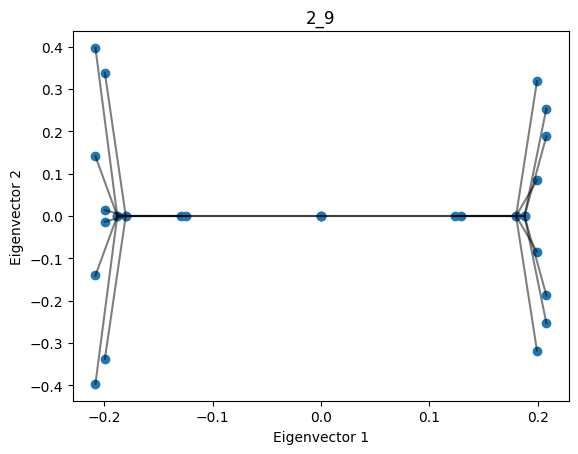

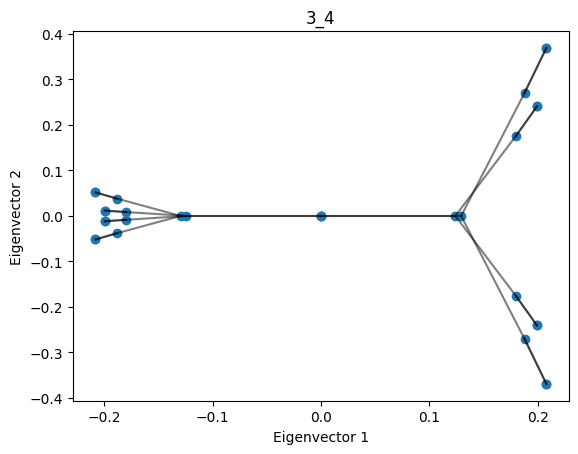

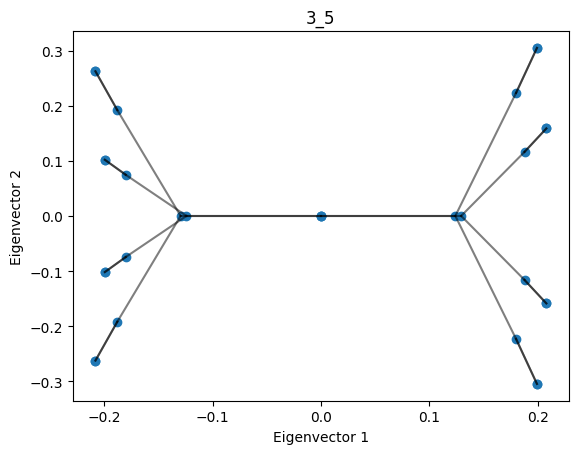

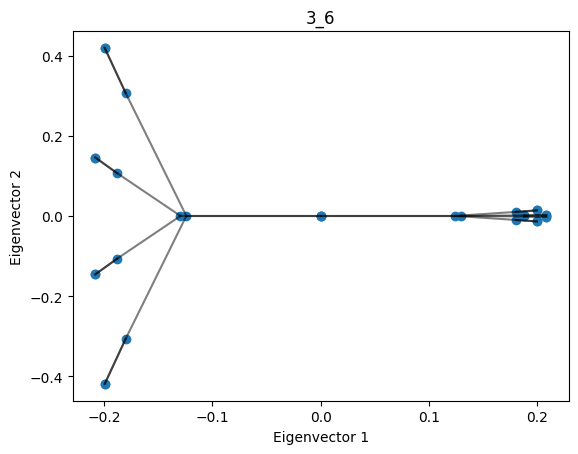

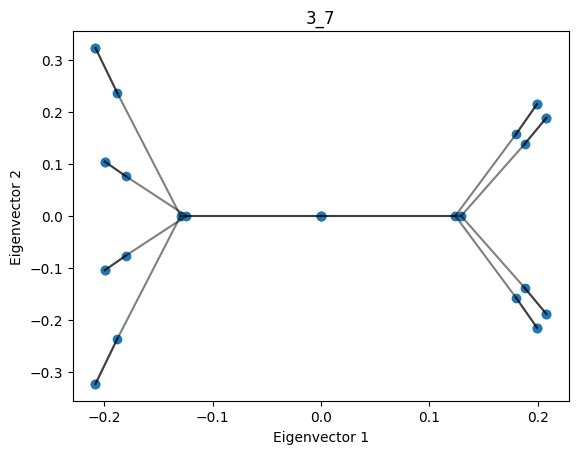

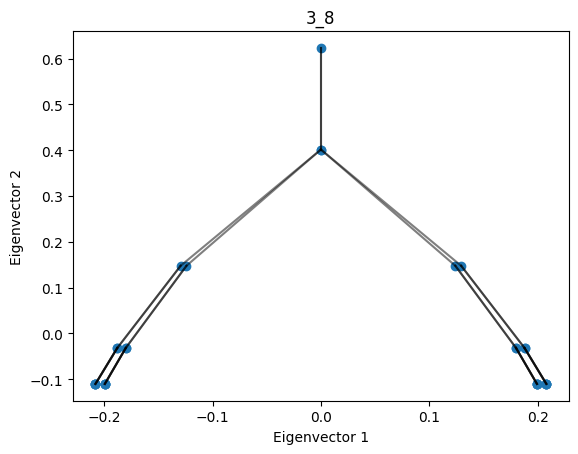

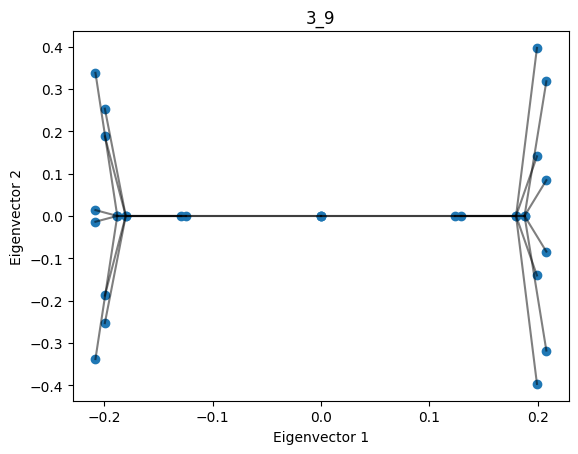

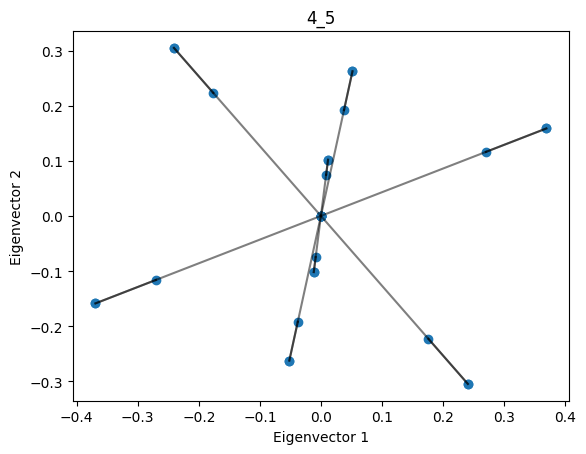

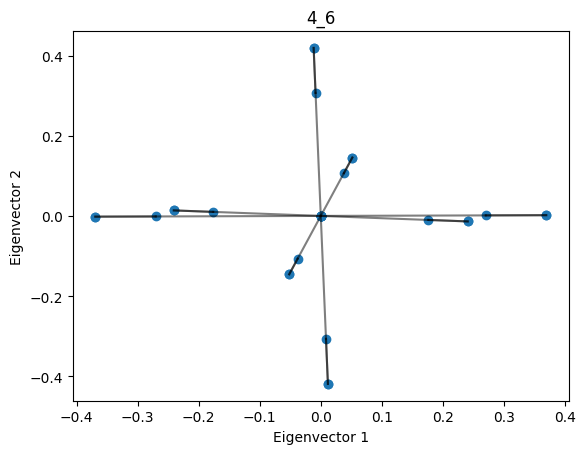

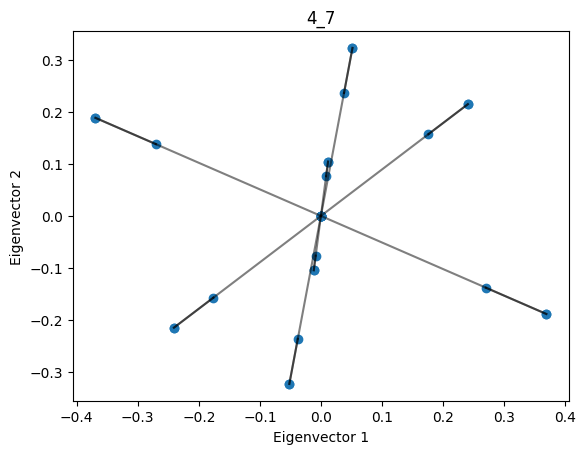

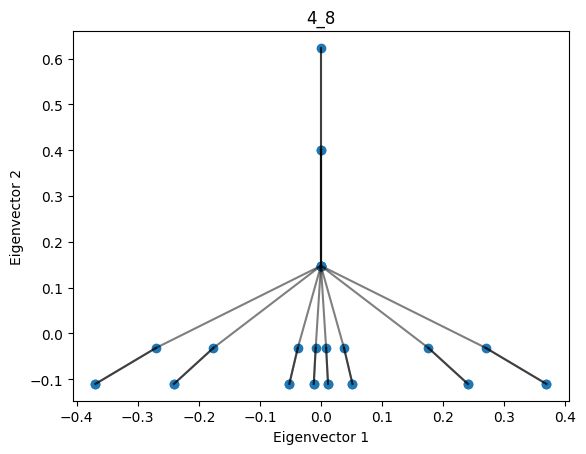

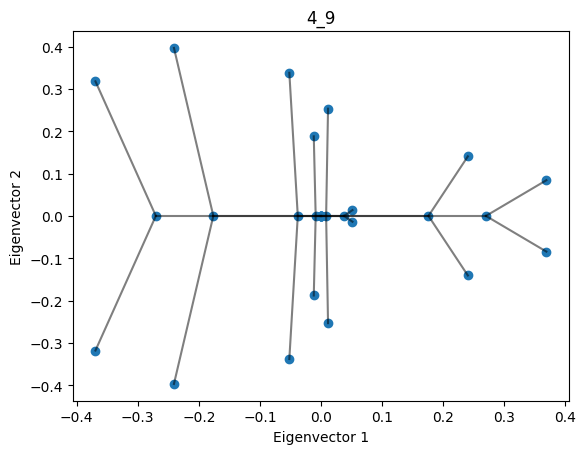

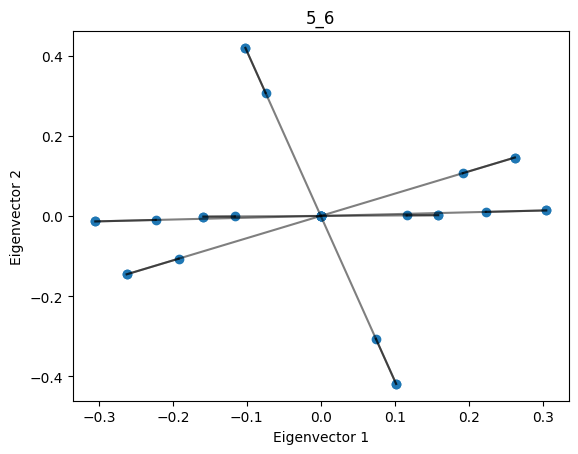

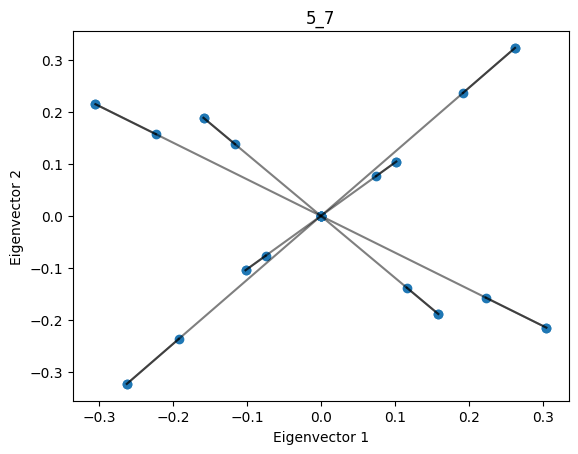

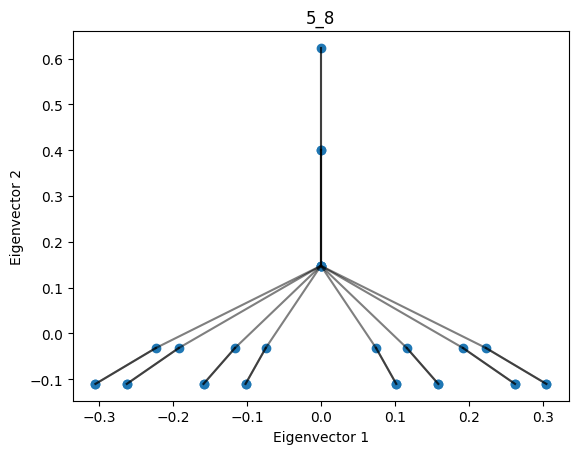

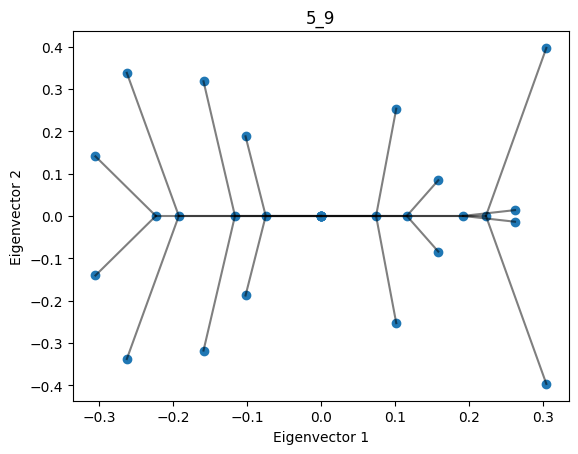

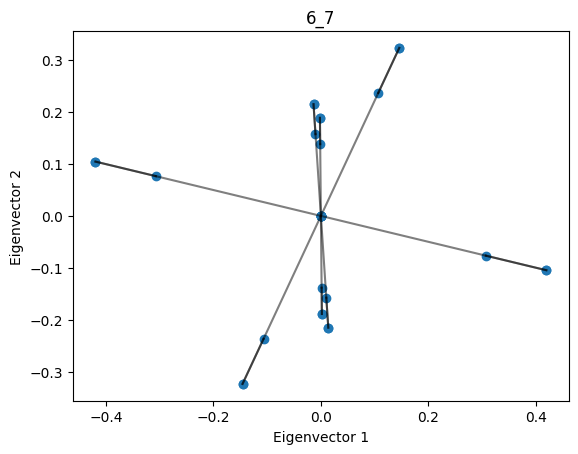

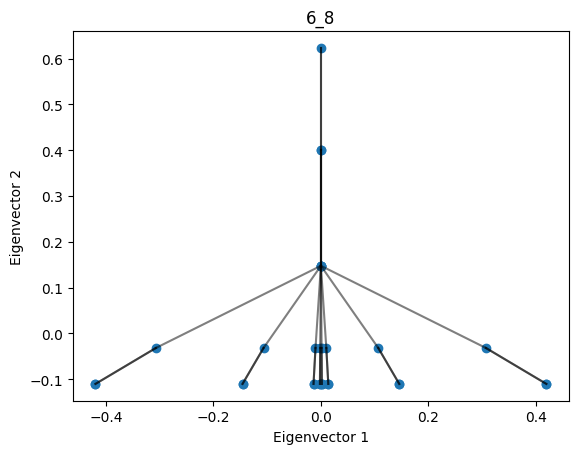

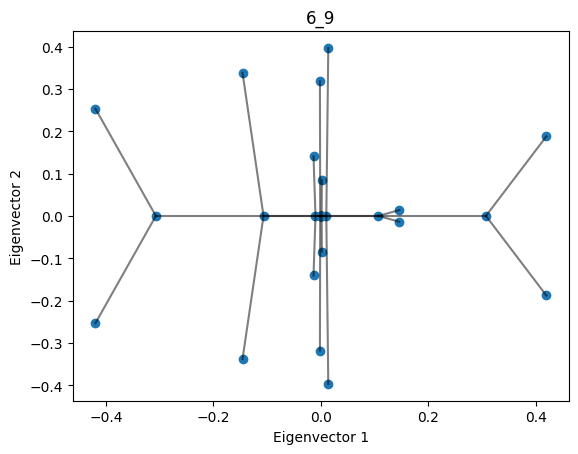

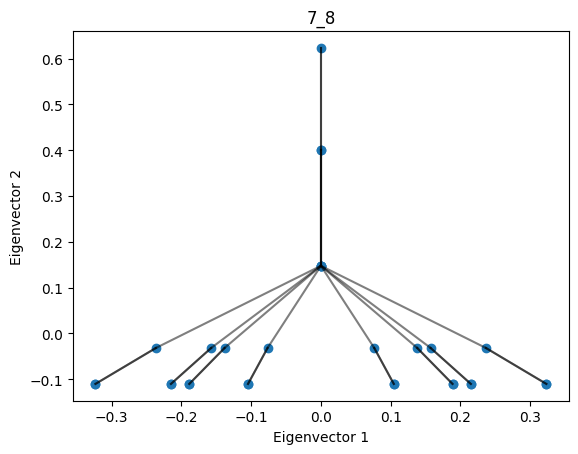

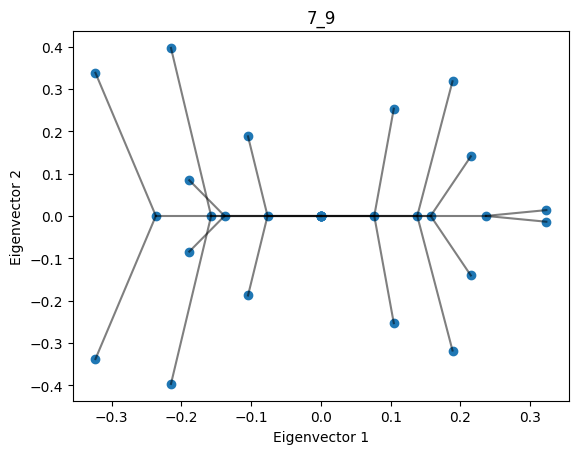

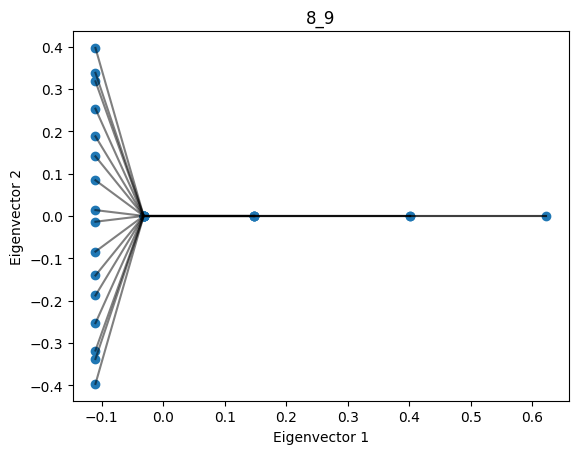

In [312]:
for i in range(embed_dim-1):
    for j in range(i+1,embed_dim):
        plot_graph_with_edges(heigvecs[1:,i],heigvecs[1:,j],adjacency_matrix, title = f'{i}_{j}')

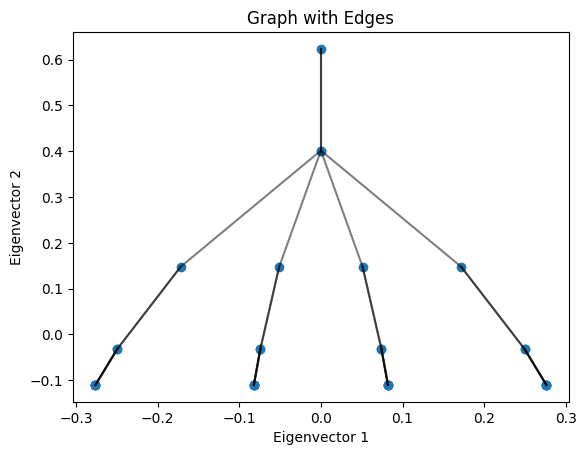

In [299]:
plot_graph_with_edges(heigvecs[1:,2],heigvecs[1:,8],adjacency_matrix)